# Выбор локации для скважины

Необходимо определить, регион, в котором нефтедобывающая компания будет бурить скважину. Условия:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

В этой главе мы:
* загрузим данные;
* проведем базовый анализ;
* разделим данные на тренировочные и валидационные;
* пронормируем числовые данные;

### Знакомство с данными:

In [7]:
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

In [24]:
df_null = pd.read_csv('/datasets/geo_data_0.csv')
df_one = pd.read_csv('/datasets/geo_data_1.csv')
df_two = pd.read_csv('/datasets/geo_data_2.csv')

In [25]:
# создадим список с таблицами по регионам

dfs = [df_null, df_one, df_two]

Посмотрим данные в таблицах:

In [26]:
# посмотрим информацию о каждой таблице

for df in dfs:
    display(df.info())
    display(df.describe().T)
    display(df.head())

Данные находятся в 3 таблицах, каждая таблица соответствует своему региону.

### Предобработка данных

Проверим таблицы на наличие явных дупликатов и пропусков:

In [27]:
# посмотрим наличие дупликатов и пропусков в каждом наборе

for df in dfs:
    print(df.duplicated().sum())
    print(df.isnull().sum())

В таблицах отсутствуют пропуски и явные дупликаты.

### Анализ

Построим для каждой таблицы матрицы корреляций:

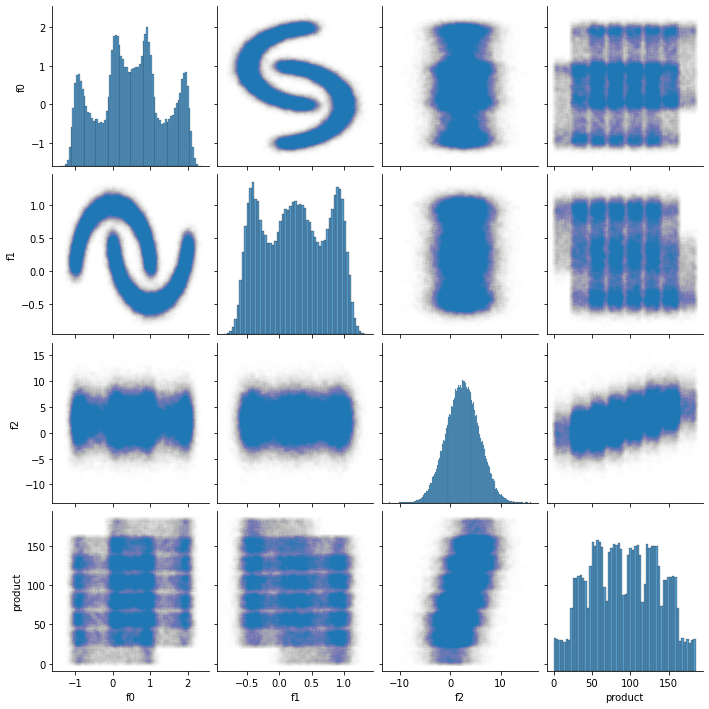

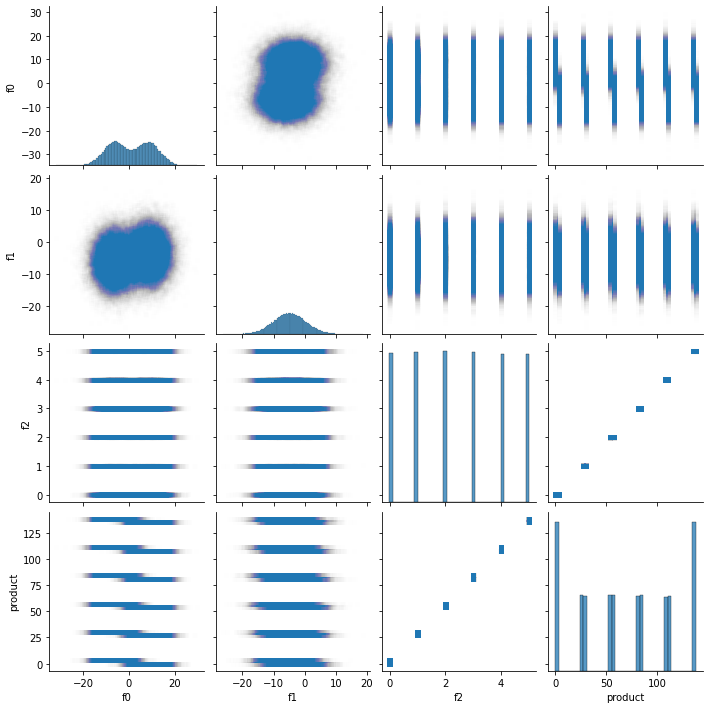

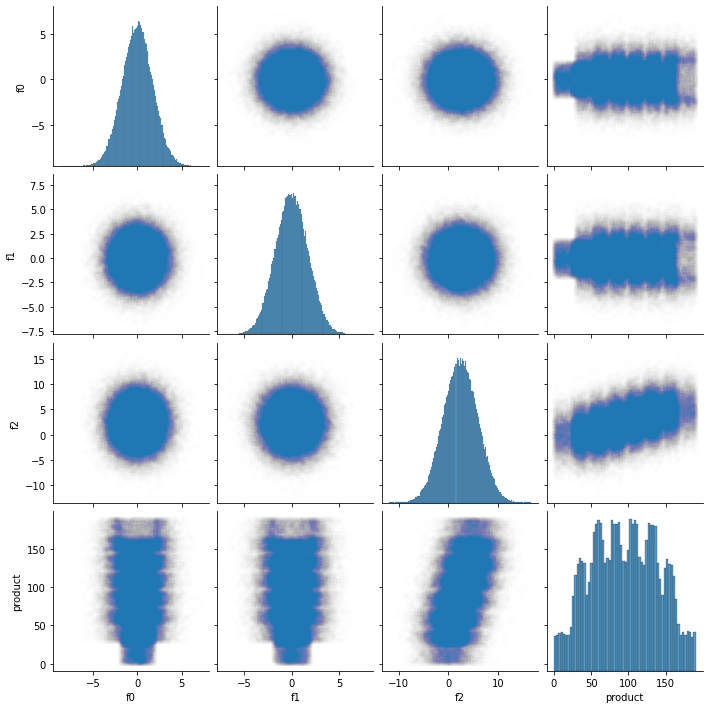

In [28]:

count = 0
# для каждого региона построим гистограмму матрицы корреляций и гистограммы
for df in dfs:
    print(f'Для региона {count}')
    plt.figure(figsize=(10, 5))
    sns.pairplot(data=df, plot_kws=dict(alpha=0.005))
    
    plt.show()
    
    count += 1    

Данные по условию задачи синтетические, причём данные по первому и третьему региону имеют практически нормальное распределение, но на матрицах корреляции видны широкие полосы, для какого-то значения коэффициента чаще соотвествует какое-то определенное значение `product`, но данные сильно зашумленны. 

Во втором регионе данные практически не зашумлены. В реальности возникли бы вопросы по поводу этих данных.

### Подготовка данных

In [29]:
# создадим пустые списки с предикторами и целевым показателем
# в них будут храниться предикторы и цели для каждого региона соответственно
targets = []
features = []

# для каждого набора данных выделим предикторы и целевые показатели и запишем их в списки targets и features

for df in dfs:
    target = df['product']
    feature = df.drop(['id','product'], axis=1)
    targets.append(target)
    features.append(feature)
    
    

In [30]:
for feature, target in zip(features, targets):
    display(feature.head())
    display(target.head())

In [31]:
# создадим список с числовыми данными

numeric = ['f0', 'f1', 'f2']

# создадим списки для тренировочных и валидационных наборов

features_train = []
features_valid = []

targets_train = []
targets_valid = []

# для каждого набора данных сделаем разбивку на тренировочную и валидационную выборку, затем отнормируем данные
# и запишем их в соответствующие списки

for feature, target in zip(features, targets):
    
    feature_train, feature_valid, target_train, target_valid = train_test_split(feature,
                                                                               target,
                                                                               test_size=.25,
                                                                              random_state=12345)
    scaler = StandardScaler()
    scaler.fit(feature_train[numeric])
    feature_train[numeric] = scaler.transform(feature_train[numeric])
    feature_valid[numeric] = scaler.transform(feature_valid[numeric])
    
    features_train.append(feature_train)
    features_valid.append(feature_valid)
    
    targets_train.append(target_train)
    targets_valid.append(target_valid)
    

In [32]:
# для каждого набора выведем размер выборки и выведем 5 первых строк таблицы

for feature_train, feature_valid, target_train, target_valid in zip(features_train,
                                                                    features_valid,
                                                                    targets_train,
                                                                    targets_valid):
    print(f'Размер тренировочной выборки {len(feature_train)}')
    print(f'Размер валидационной выборки {len(feature_valid)}')
    display(feature_train.head())
    display(target_train.head())

### Вывод

* В данных отсутсвтуют пропуски и явные дупликаты;
* анализ позволяет удостовериться в том, что данные синтетические;
* данные по второму региону сильно отличаются, видны явные корреляции, стоит ожидать высокого качества модели;
* были получены тренировочные и валидационные наборы для каждого региона.

## Обучение и проверка модели

В этой главе мы:
* Обучим модели для каждого региона;
* проверим их на валидационной выборке;
* сохраним предсказанные и правильные значения в отдельные таблицы.

In [33]:
models = [] # в этом списке будем хранить получившиеся модели

rmses = [] # список ошибок


predict_target_dfs = [] # здесь мы будем хранить результаты предсказаний и реальные значения


for feature_train, feature_valid, target_train, target_valid in zip(features_train,
                                                                    features_valid,
                                                                    targets_train,
                                                                    targets_valid):
    model = LinearRegression()
    model.fit(feature_train, target_train)
    models.append(model)
    predictions = model.predict(feature_valid)
    mse = mean_squared_error(target_valid, predictions)
    
    prediction_series = pd.Series(predictions) # преобразуем предсказания в Series
    prediction_series.name = 'predict' # поменяем название столбца для удобства
    
    # создадим датафрейм с предсказаниями и реальным значением, причём, нам необходимо сбросить индексы 
    # реального значения, так как в столбце с предсказаниями индексы обнулены
    predict_target_df = pd.concat([target_valid.reset_index(drop=True), prediction_series], axis=1)
    
    # добавим полученные датафреймы в список
    predict_target_dfs.append(predict_target_df)
    # добавим полученные ошибки в список
    rmses.append(mse**.5)
      

In [34]:
for rmse, predictions_target in zip(rmses, predict_target_dfs):
    print(f'RMSE: {rmse}')
    print(f'Предсказанное среднее:{predictions_target["predict"].mean():.2f}')
    display(predictions_target.head())

### Вывод

* Для каждого региона были обучены модели и сохранены результаты на выборках валидации и соотвествующие им реальные значения в отдельные таблицы;
* Предсказанные средние значения и ошибки:
    * Первый регион - 92 тысячи бареллей на скажину, при этом стандартная ошибка - 37.6;
    * Второй регион - 69 тысяч бареллей на скважину, при этом ошибка 0.9;
    * Третий регион - 95 тысяч бареллей на скважину, при этом ошибка 40.

Стоит отметить, что во втором регионе среднее значение меньше, но, из-за малой ошибки, следует ожидать от него лучший результат.


## Подготовка к расчёту прибыли

Обозначим все параметры:

In [35]:
NUMBER_OF_WELLS = 500 # количество скважин для исследования
NUMBER_OF_BEST = 200 # количество лучших скважин для разработки
BUDGET = 10**10 # бюджет на разработку в регионе
INCOME_PER_PRODUCT = 450 * 10**3 # доход с тысячи баррелей
LOSS_PROBA = .025 # вероятность убытков

Посчитаем минимальное среднее значение в одной скважине, необходимое для безубыточности:

In [36]:
# расчёт количества тысячей баррелей чтобы не было убытков
# считаем, сколько в среднем должно быть в одной скважине, чтобы перекрыть вложения:
product_min = BUDGET / (INCOME_PER_PRODUCT * NUMBER_OF_BEST)
print(f'Минимальное среднее значение количества баррелей в лучших скважинах: {product_min:.2f} тысяч.')

Сравним средний запас с необходимым средним:

In [37]:
count = 0

for df in dfs:
    print(f'''Среднее значение по региону {count}: {df["product"].mean():.2f},
          а минимальное среднее среди скважин: {product_min:.2f}''')
    count += 1

### Вывод

* Минимальные средние значения скважин, необходимые для безубыточности - 111.11 тысяч бареллей;
* Среднее первого региона - 92.5 тысяч;
* Среднее второго региона - 68.83 тысяч;
* Среднее третьего региона - 95 тысяч;
* Средние значения по регионам меньше, чем необходимые средние, из этого можно сделать вывод, что нам необходимо применять модель, чтобы отобрать лучшие скважины, иначе, если брать случайные скважины, вероятность убытков очень велика.

## Расчёт прибыли и рисков 

В этой главе мы:
* напишем функцию по расчёту прибыли;
* с помощью техники bootstrap рассчитаем вероятность убытков;
* посчитаем 2.5% и 97.5% квантили для каждого региона.

### Функция для расчёта прибыли

Напишем функцию для расчёта прибыли для выбранных скважин, отсортированных по предсказаниям:

In [38]:
def revenue(predict_target_df, income_per_product, number_of_best, budget):
    # на вход получает таблицу с предсказаниями и реальным значением, а также количество лучших скважин и бюджет
    # отсортируем таблицу по значениям предсказаний    
    predict_target_df_sorted = predict_target_df.sort_values(by='predict',
                                                             ascending=False)
    
    # возьмем первые 200 скважин, с наибольшим предсказанием
    best_wells = predict_target_df_sorted.head(number_of_best)
    
    # посчитаем для них объем и выручку и средний объем
    total_volume = best_wells['product'].sum()
    revenue = total_volume * income_per_product - budget
    mean_volume = best_wells['product'].mean()
    
    return total_volume, revenue, mean_volume
    

### Оценка рисков с помощью bootstrap

С помощью техники bootstrap оценим риски:
* возьмем по тысяче случайных выборок в каждом регионе;
* для каждой выборки применим функцию для расчёта прибыли;
* запишим все значения в список;
* каждый список для каждого региона поместим в список.

In [39]:
state = np.random.RandomState(12345)

# создадим список для значений прибылей для каждого региона 
revenues_distribution = []
# bootstrap для каждого региона, здесь применяются таблицы с значениями предсказаний и реальными значениями
for predict_target_df in predict_target_dfs:
    
    revenues = []

    for i in range(1000):
        # выделяем подвыборку из таблицы предсказаний и реальных значений для каждого региона
        predict_target_sample = predict_target_df.sample(NUMBER_OF_WELLS, replace=True, random_state=state)
        
        # добавляем в список с прибылями значения прибыли для каждой подвыборки
        revenues.append(revenue(predict_target_sample, INCOME_PER_PRODUCT, NUMBER_OF_BEST, BUDGET)[1])
    
    revenues = pd.Series(revenues) # для удобства преобразуем в Series 
    
    revenues.name = 'Revenue' # для удобства
    # добавляем Series с значениями прибыли для каждой подвыборки в список для каждого региона
    revenues_distribution.append(revenues) 

Таким образом, мы получили список с `Series`, в каждом из которых собраны значения прибылей для каждой подвыборки.

Для каждого региона выведем:
* Значение средней прибыли среди всех подвыборок;
* 2.5 % квантиль;
* 97.5% квантиль;
* вероятность убытков;
* построим распределение прибылей.

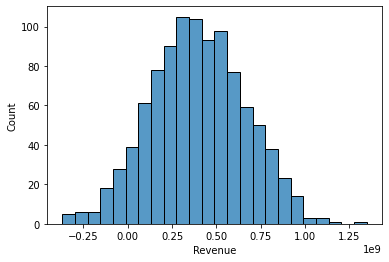

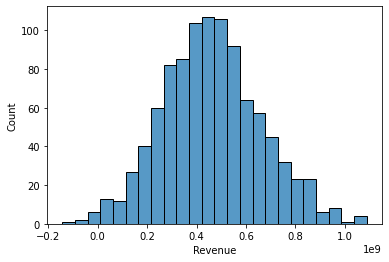

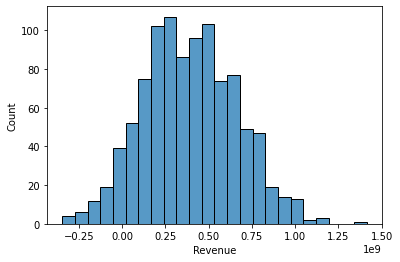

In [40]:
count = 0

for revenues in revenues_distribution:
     
    
    sns.histplot(revenues)
    
    print(f'---------------В регионе {count}---------------')
    print(f'Cредняя прибыль равна: {revenues.mean() / 10**6:.2f} миллионов')
    print(f'2.5% квантиль равен: {revenues.quantile(.025) / 10**6:.2f} миллионов')
    print(f'97.5% квантиль равен: {revenues.quantile(.975) / 10**6:.2f} миллионов')
    
    proba_loss = (revenues < 0).mean() * 100 
    
    print(f'Вероятность убытков:{proba_loss:.2f} %')
    
    if proba_loss < LOSS_PROBA:
        print(f'Регион подходит, вероятность убытка менее {LOSS_PROBA * 100}%')
    else:
        print(f'Регион не подходит, вероятность убытков более {LOSS_PROBA * 100}%')
    
    count += 1
    
    plt.show()

### Вывод


* Из всех регионов, вероятность убытков менее `2.5%` только у второго региона, вероятность убытков в первом и третьем более `6%`.
* средняя прибыль по регионам:
    * 1 - 396 млн.
    * 2 - 461 млн.
    * 3 - 393 млн.
* 2.5% квантиль по регионам:
    * 1 - -111 млн;
    * 2 - 78 млн;
    * 3 - -112млн;
* 97.5% квантиль по регионам:
    * 1 - 910 млн;
    * 2 - 863;
    * 3 - 935;
* Вероятность убытков по регионам:
    * 1 - 6.9%;
    * 2 - 0.7%
    * 3 - 6.5%
* Из всех регионов, вероятность убытков менее `2.5%` только у второго региона, вероятность убытков в первом и третьем более `6%`, таким образом, можно сделать вывод, что наиболее подходящим оказывается второй из трёх регион.

При этом, стоит отметить, что среднее количество запасов на скважину во втором регионе значительно меньше, около 70 против 95 у двух других, при этом вероятность убытков значительно меньше, что связано с тем, что модель для второго региона работает намного лучше и ошибка модели минимальна. Если бы данные по первому и третьему региону позволили бы получить равноценную по точности модель, то вероятную прибыль можно было бы ожидать намного выше, чем у второго регоина.


## Общий вывод

* В данных отсутсвтуют пропуски и явные дупликаты;
* анализ позволяет удостовериться в том, что данные синтетические;
* данные по второму региону сильно отличаются, видны явные корреляции, стоит ожидать высокого качества модели;
* были получены тренировочные и валидационные наборы для каждого региона.
* Для каждого региона были обучены модели и сохранены результаты на выборках валидации и соотвествующие им реальные значения в отдельные таблицы;
* Предсказанные средние значения и ошибки:
    * Первый регион - 92 тысячи бареллей на скажину, при этом стандартная ошибка - 37.6;
    * Второй регион - 69 тысяч бареллей на скважину, при этом ошибка 0.9;
    * Третий регион - 95 тысяч бареллей на скважину, при этом ошибка 40.

* Стоит отметить, что во втором регионе среднее значение меньше, но, из-за малой ошибки, следует ожидать от него лучший результат.
* Минимальные средние значения скважин, необходимые для безубыточности - 111.11 тысяч бареллей;
* Среднее первого региона - 92.5 тысяч;
* Среднее второго региона - 68.83 тысяч;
* Среднее третьего региона - 95 тысяч;
* Средние значения по регионам меньше, чем необходимые средние, из этого можно сделать вывод, что нам необходимо применять модель, чтобы отобрать лучшие скважины, иначе, если брать случайные скважины, вероятность убытков очень велика.
* Из всех регионов, вероятность убытков менее `2.5%` только у второго региона, вероятность убытков в первом и третьем более `6%`.
* средняя прибыль по регионам:
    * 1 - 396 млн.
    * 2 - 461 млн.
    * 3 - 393 млн.
* 2.5% квантиль по регионам:
    * 1 - -111 млн;
    * 2 - 78 млн;
    * 3 - -112млн;
* 97.5% квантиль по регионам:
    * 1 - 910 млн;
    * 2 - 863;
    * 3 - 935;
* Вероятность убытков по регионам:
    * 1 - 6.9%;
    * 2 - 0.7%
    * 3 - 6.5%
* Из всех регионов, вероятность убытков менее `2.5%` только у второго региона, вероятность убытков в первом и третьем более `6%`, таким образом, можно сделать вывод, что наиболее подходящим оказывается второй из трёх регион - только он удовлетворяют требованию вероятности убытков менее `2.5%`.

При этом, стоит отметить, что среднее количество запасов на скважину во втором регионе значительно меньше, около 70 против 95 у двух других, при этом вероятность убытков значительно меньше, что связано с тем, что модель для второго региона работает намного лучше и ошибка модели минимальна. Если бы данные по первому и третьему региону позволили бы получить равноценную по точности модель, то вероятную прибыль можно было бы ожидать намного выше, чем у второго регоина.
* Наиболее подходящий регион - регион, данные о котором представлены в таблице `geo_data_1`.